In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.model_selection import ParameterGrid

from recsys4daos.models import NLPSimilarity
from recsys4daos.utils import Timer
from recsys4daos.datasets import to_microsoft
from recsys4daos.evaluation import calculate_all_metrics
from recsys4daos.model_selection import cvtt_open, explore_hparams

import paths

import seaborn as sns
sns.set_theme()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/home/daviddavo/recsys4daos/.direnv/python-3.11/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Parameters

In [2]:
# Dataset config
ORG_NAME = 'Decentraland'

# Evaluation
K_RECOMMENDATIONS: list[int] = [1,3,5,10,15,100]
SPLITS_FREQ: str = 'W-THU' # split weekly
SPLITS_NORMALIZE = True # Wether or not to move everything to 00:00
LAST_FOLDS = 10 # Use just last 10 splits
LAST_FOLD_DATE_STR: str = None

# Search space config
WINDOW_SIZES = ['7d', '14d', '21d', '30d', '60d', '90d', '10YE']
MODEL_NAMES = [
    'all-mpnet-base-v2', # The one used in sbert's examples
    'all-distilroberta-v1',
    'all-MiniLM-L12-v2',
    'all-MiniLM-L6-v2',
]

OPTIM_METRIC = 'map@10'

In [3]:
# Parameters
EXECUTION_ID = "2024-09-04T10:00"
ORG_NAME = "Index Coop"
SPLITS_FREQ = "W-THU"
LAST_FOLDS = 10
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = "2023-07-13"


In [4]:
EMBEDDINGS_CACHE = Path(paths.DEFAULT_CACHE_PATH) / 'pln-embeddings'

# Load the dataset

In [5]:
dfp = paths.load_proposals(ORG_NAME, text=True)
dfv = paths.load_votes(ORG_NAME)

print(dfp.info())
print(dfv.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1052 entries, 0 to 1051
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 1052 non-null   object        
 1   author             1052 non-null   object        
 2   date               1052 non-null   datetime64[us]
 3   start              1052 non-null   datetime64[us]
 4   end                1052 non-null   datetime64[us]
 5   platform_proposal  1052 non-null   object        
 6   title              1052 non-null   object        
 7   description        1052 non-null   object        
dtypes: datetime64[us](3), object(5)
memory usage: 65.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24031 entries, 0 to 24030
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        24031 non-null  object        
 1   proposal  24031 non-null  ob

In [6]:
df = to_microsoft(dfv)
df

,userID,itemID,timestamp,rating
0,0xf3862af14cbb4d9b781e41a3d4d74e7c2cdb73e2,e03585d8-6ab1-52d0-8d05-6b20a2f457b9,2020-11-18 20:56:32,1
1,0xba71dfe1801d125ba201e8bebf7f0b9764d4b19b,e03585d8-6ab1-52d0-8d05-6b20a2f457b9,2020-11-18 21:23:13,1
2,0x042a135bd342910ad7f67bbda74e3fd4125d1272,e03585d8-6ab1-52d0-8d05-6b20a2f457b9,2020-11-18 21:23:55,1
3,0x21f3ef56cd8bafd9448515e4508077c16ecc1f35,e03585d8-6ab1-52d0-8d05-6b20a2f457b9,2020-11-18 21:42:37,1
4,0x506f92308f4d9a2f764d80c68ebc50830a2f7a11,e03585d8-6ab1-52d0-8d05-6b20a2f457b9,2020-11-18 21:45:10,1
...,...,...,...,...
24026,0x9ec14a04cb7822b56bef9d46357604b6f3a673cc,a3350420-69f0-5ca3-98a5-ebe60952bed1,2023-07-18 05:34:29,1
24027,0x53c40473dcdfd927c4201ccfe24e314a7d7c3584,a3350420-69f0-5ca3-98a5-ebe60952bed1,2023-07-18 18:42:04,1
24028,0x197008a1d3e26a97a19f46c121482969cef95b7d,a3350420-69f0-5ca3-98a5-ebe60952bed1,2023-07-18 23:58:06,1
24029,0x24749aedf18208ab74a8110e07e820286bb5acf8,a3350420-69f0-5ca3-98a5-ebe60952bed1,2023-07-19 00:31:54,1


## Split in folds

In [7]:
all_folds = { f.end:f for f in cvtt_open(
    df, SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', last_fold=LAST_FOLD_DATE_STR,
)}
last_folds_idx = list(all_folds.keys())[-LAST_FOLDS:]
last_folds_idx

[Timestamp('2023-05-11 00:00:00'),
 Timestamp('2023-05-18 00:00:00'),
 Timestamp('2023-05-25 00:00:00'),
 Timestamp('2023-06-01 00:00:00'),
 Timestamp('2023-06-08 00:00:00'),
 Timestamp('2023-06-15 00:00:00'),
 Timestamp('2023-06-22 00:00:00'),
 Timestamp('2023-06-29 00:00:00'),
 Timestamp('2023-07-06 00:00:00'),
 Timestamp('2023-07-13 00:00:00')]

# Similarity PLN

In [8]:
def testHParamsPLNSimilarity(fold, window_size, model_name):
    f = all_folds[fold]
    
    model = NLPSimilarity(dfp, EMBEDDINGS_CACHE, model_name=model_name)

    offset = pd.tseries.frequencies.to_offset(window_size)
    train = f.train[f.train['timestamp'] > (f.end - offset)]

    with Timer() as t_fit:
        model.fit(train)

    with Timer() as t_rec:
        # Truncate the top_k
        top_k = max(K_RECOMMENDATIONS)
        users = np.intersect1d(f.test['userID'].unique(), train['userID'].unique())
        recs = model.recommend_k_items(users, top_k=min(len(f.open_proposals), top_k), recommend_from=f.open_proposals)
    
    return {
        'time_train': t_fit.time,
        'time_rec': t_rec.time,
        'rec_users': len(users),
        **calculate_all_metrics(f.test, recs, K_RECOMMENDATIONS),
    }

# testHParamsPLNSimilarity(last_folds_idx[0], '14D', MODEL_NAMES[0])

In [9]:
# Populate the cache of embeddings for each model
from recsys4daos.models.nlp import NLPModel

for m in MODEL_NAMES:
    NLPModel(dfp, EMBEDDINGS_CACHE, model_name=m).fit()

In [10]:
results = explore_hparams(
    testHParamsPLNSimilarity,
    ParameterGrid({
        'fold': last_folds_idx,
        'model_name': MODEL_NAMES,
        'window_size': WINDOW_SIZES,
    }),
    paths.hparams_progress('pln-similarity', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE),
)
mdf = pd.DataFrame(results)
mdf

Restored checkpoint from ../.cache/Index Coop/hparams-pln-similarity_W-THU_normalize.pkl with 280 results


  0%|          | 0/280 [00:00<?, ?it/s]

,fold,model_name,window_size,time_train,time_rec,rec_users,precision@1,precision@3,precision@5,precision@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
0,2023-05-11,all-mpnet-base-v2,7d,0.228449,0.001352,8,0.625000,0.416667,0.400000,0.325000,...,1.0,1.0,1.0,0.278571,0.523810,0.635714,0.692857,0.692857,0.692857,0.128467
1,2023-05-11,all-mpnet-base-v2,14d,0.080302,0.001364,9,0.555556,0.407407,0.377778,0.311111,...,1.0,1.0,1.0,0.350000,0.492063,0.613095,0.660714,0.660714,0.660714,0.128833
2,2023-05-11,all-mpnet-base-v2,21d,0.236449,0.001335,9,0.444444,0.370370,0.377778,0.311111,...,1.0,1.0,1.0,0.312500,0.408730,0.553571,0.577381,0.577381,0.577381,0.127247
3,2023-05-11,all-mpnet-base-v2,30d,0.084641,0.001331,9,0.555556,0.444444,0.377778,0.311111,...,1.0,1.0,1.0,0.278571,0.452381,0.564286,0.592857,0.592857,0.592857,0.128004
4,2023-05-11,all-mpnet-base-v2,60d,0.244765,0.001409,9,0.666667,0.444444,0.400000,0.311111,...,1.0,1.0,1.0,0.315476,0.460317,0.553571,0.577381,0.577381,0.577381,0.126917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,2023-07-13,all-MiniLM-L6-v2,21d,0.216291,0.001245,4,0.250000,0.250000,0.300000,0.275000,...,1.0,1.0,1.0,0.125000,0.375000,0.625000,1.000000,1.000000,1.000000,0.124486
276,2023-07-13,all-MiniLM-L6-v2,30d,0.221554,0.001260,4,0.250000,0.333333,0.300000,0.275000,...,1.0,1.0,1.0,0.125000,0.375000,0.625000,1.000000,1.000000,1.000000,0.124617
277,2023-07-13,all-MiniLM-L6-v2,60d,0.072256,0.001279,4,0.250000,0.250000,0.300000,0.275000,...,1.0,1.0,1.0,0.125000,0.375000,0.625000,1.000000,1.000000,1.000000,0.124607
278,2023-07-13,all-MiniLM-L6-v2,90d,0.231041,0.001311,4,0.250000,0.250000,0.300000,0.275000,...,1.0,1.0,1.0,0.125000,0.375000,0.625000,1.000000,1.000000,1.000000,0.124678


<Axes: xlabel='window_size', ylabel='map@10'>

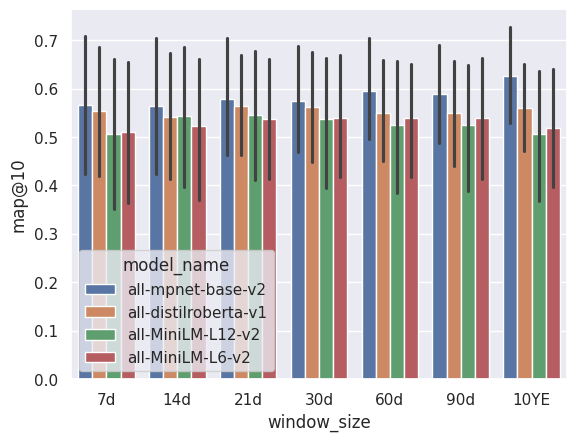

In [11]:
sns.barplot(mdf, x='window_size', y=OPTIM_METRIC, hue='model_name')

## Best overall hparams

In [12]:
display_columns = ['time_train'] + [ c for c in mdf.columns if c.endswith('@5') or c.endswith('@10') or c.endswith('@100') ]
hparam_cols = ['window_size', 'model_name']
overall_hparams = mdf[mdf['fold'] > last_folds_idx[0]].groupby(hparam_cols).mean().sort_values(OPTIM_METRIC, ascending=False)
overall_hparams[display_columns]

,,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
window_size,model_name,,,,,,,,,,,,,,,,
10YE,all-mpnet-base-v2,2.237503,0.285300,0.182200,0.019192,0.673639,0.723128,0.736063,0.600520,0.629045,0.635981,0.808730,0.960648,1.0,0.812191,0.871682,0.871682
60d,all-mpnet-base-v2,0.209682,0.290988,0.191526,0.019523,0.589813,0.641618,0.644555,0.560880,0.598393,0.601080,0.794610,0.990741,1.0,0.781481,0.843981,0.843981
90d,all-mpnet-base-v2,0.184064,0.292840,0.195229,0.020356,0.594624,0.648951,0.657968,0.553625,0.589909,0.595630,0.789594,0.974537,1.0,0.780093,0.852469,0.852469
21d,all-mpnet-base-v2,0.151016,0.289444,0.191019,0.019843,0.523875,0.579753,0.588583,0.546127,0.584911,0.590502,0.756250,0.962963,1.0,0.755886,0.818386,0.818386
30d,all-mpnet-base-v2,0.168312,0.291914,0.190401,0.019781,0.531068,0.581207,0.589990,0.541900,0.577649,0.583136,0.774769,0.962963,1.0,0.754034,0.816534,0.816534
21d,all-distilroberta-v1,0.185298,0.296852,0.194722,0.019843,0.525668,0.572016,0.574759,0.536188,0.569942,0.572168,0.810880,0.990741,1.0,0.726808,0.789308,0.789308
7d,all-mpnet-base-v2,0.181750,0.264974,0.167672,0.017693,0.442952,0.481193,0.491415,0.529211,0.563492,0.569680,0.759259,0.958333,1.0,0.787698,0.841270,0.841270
14d,all-mpnet-base-v2,0.182450,0.258069,0.166997,0.017255,0.479800,0.531394,0.537849,0.520536,0.560123,0.564031,0.744213,0.972222,1.0,0.779539,0.826414,0.826414
30d,all-distilroberta-v1,0.153043,0.288210,0.194105,0.019781,0.520141,0.573202,0.575945,0.521128,0.559424,0.561650,0.792361,0.990741,1.0,0.764087,0.834400,0.834400


In [13]:
best_avg_hparams = mdf.set_index(hparam_cols).loc[overall_hparams.iloc[0].name].reset_index().set_index(['fold', *hparam_cols])
paths.save_model_results(best_avg_hparams, 'plnsim-best-avg', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
best_avg_hparams

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Index Coop/models/plnsim-best-avg_W-THU_normalize.parquet


/tmp/ipykernel_3818339/971293119.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  best_avg_hparams = mdf.set_index(hparam_cols).loc[overall_hparams.iloc[0].name].reset_index().set_index(['fold', *hparam_cols])


,,,time_train,time_rec,rec_users,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
fold,window_size,model_name,,,,,,,,,,,,,,,,,,,,,
2023-05-11,10YE,all-mpnet-base-v2,2.133333,0.004210,10,0.700000,0.500000,0.420000,0.330000,0.220000,0.033000,0.700000,...,1.000000,1.000000,1.0,0.298980,0.457738,0.552679,0.570536,0.570536,0.570536,0.126168
2023-05-18,10YE,all-mpnet-base-v2,2.290352,0.003938,8,0.625000,0.291667,0.175000,0.187500,0.175000,0.027500,0.625000,...,0.645833,0.986111,1.0,0.372222,0.416667,0.416667,0.483333,0.483333,0.483333,0.127396
2023-05-25,10YE,all-mpnet-base-v2,2.142430,0.003991,10,0.300000,0.233333,0.280000,0.140000,0.093333,0.014000,0.300000,...,1.000000,1.000000,1.0,0.777778,0.888889,0.888889,0.888889,0.888889,0.888889,0.124699
2023-06-01,10YE,all-mpnet-base-v2,2.305178,0.004036,6,0.333333,0.333333,0.200000,0.100000,0.066667,0.010000,0.333333,...,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.122583
2023-06-08,10YE,all-mpnet-base-v2,2.147212,0.004349,6,0.833333,0.388889,0.233333,0.116667,0.077778,0.011667,0.833333,...,1.000000,1.000000,1.0,1.000000,0.916667,0.916667,0.916667,0.916667,0.916667,0.123293
2023-06-15,10YE,all-mpnet-base-v2,2.316686,0.004171,6,0.500000,0.277778,0.366667,0.300000,0.200000,0.030000,0.500000,...,1.000000,1.000000,1.0,0.708333,0.612500,0.775000,0.868750,0.868750,0.868750,0.124842
2023-06-22,10YE,all-mpnet-base-v2,2.150605,0.003725,7,0.428571,0.428571,0.257143,0.128571,0.085714,0.012857,0.428571,...,1.000000,1.000000,1.0,0.666667,1.000000,1.000000,1.000000,1.000000,1.000000,0.123795
2023-06-29,10YE,all-mpnet-base-v2,2.315041,0.003966,7,0.571429,0.285714,0.200000,0.114286,0.076190,0.011429,0.571429,...,1.000000,1.000000,1.0,0.875000,0.875000,0.875000,0.875000,0.875000,0.875000,0.124815
2023-07-06,10YE,all-mpnet-base-v2,2.312671,0.003977,9,0.777778,0.740741,0.555556,0.277778,0.185185,0.027778,0.777778,...,1.000000,1.000000,1.0,0.357143,0.750000,0.812500,0.812500,0.812500,0.812500,0.124064


## best hparams by fold

In [14]:
print("Best hyperparams by fold", OPTIM_METRIC)
best_hparams = mdf.sort_values(OPTIM_METRIC,ascending=False).drop_duplicates(['fold'], keep='first').sort_values('fold').set_index(['fold', 'model_name', 'window_size'])
paths.save_model_results(best_hparams, 'plnsim-best-val', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
best_hparams[display_columns]

Best hyperparams by fold map@10
Saved dataframe into /home/daviddavo/recsys4daos/data/output/Index Coop/models/plnsim-best-val_W-THU_normalize.parquet


,,,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
fold,model_name,window_size,,,,,,,,,,,,,,,,
2023-05-11,all-distilroberta-v1,10YE,2.132075,0.360000,0.330000,0.033000,0.556061,0.738601,0.738601,0.469417,0.608438,0.608438,0.566190,1.000000,1.0,0.630272,0.694898,0.694898
2023-05-18,all-mpnet-base-v2,60d,0.095610,0.133333,0.166667,0.020000,0.278728,0.449997,0.476425,0.291667,0.415476,0.439660,0.291667,0.916667,1.0,0.437500,0.437500,0.437500
2023-05-25,all-MiniLM-L12-v2,14d,0.068237,0.314286,0.157143,0.015714,0.510892,0.510892,0.510892,0.626984,0.626984,0.626984,1.000000,1.000000,1.0,0.888889,0.888889,0.888889
2023-06-01,all-MiniLM-L12-v2,14d,0.068233,0.200000,0.100000,0.010000,0.648798,0.648798,0.648798,0.700000,0.700000,0.700000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000
2023-06-08,all-mpnet-base-v2,7d,0.229815,0.233333,0.116667,0.011667,0.948904,0.948904,0.948904,0.930556,0.930556,0.930556,1.000000,1.000000,1.0,0.916667,0.916667,0.916667
2023-06-15,all-mpnet-base-v2,10YE,2.316686,0.366667,0.300000,0.030000,0.622356,0.736143,0.736143,0.542500,0.636956,0.636956,0.683333,1.000000,1.0,0.775000,0.868750,0.868750
2023-06-22,all-distilroberta-v1,7d,0.235820,0.300000,0.150000,0.015000,0.518704,0.518704,0.518704,0.875000,0.875000,0.875000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000
2023-06-29,all-mpnet-base-v2,10YE,2.315041,0.200000,0.114286,0.011429,0.751694,0.778062,0.778062,0.671429,0.687302,0.687302,0.928571,1.000000,1.0,0.875000,0.875000,0.875000
2023-07-06,all-mpnet-base-v2,21d,0.081818,0.575000,0.287500,0.028750,0.804139,0.804139,0.804139,0.857639,0.857639,0.857639,1.000000,1.000000,1.0,0.857143,0.857143,0.857143


In [15]:
best_hparams.describe()[display_columns]

,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000
mean,0.776486,0.308262,0.205560,0.020889,0.604801,0.663102,0.665745,0.646519,0.689391,0.691809,0.801143,0.991667,1.0,0.800547,0.853885,0.853885
std,1.023368,0.127110,0.095315,0.009438,0.195996,0.164359,0.160724,0.203002,0.158876,0.154363,0.260328,0.026352,0.0,0.183140,0.172738,0.172738
min,0.068233,0.133333,0.100000,0.010000,0.278728,0.449997,0.476425,0.291667,0.415476,0.439660,0.291667,0.916667,1.0,0.437500,0.437500,0.437500
25%,0.085266,0.208333,0.125000,0.012500,0.512845,0.512845,0.512845,0.510625,0.613075,0.613075,0.595476,1.000000,1.0,0.666454,0.860045,0.860045
50%,0.225671,0.307143,0.161905,0.017857,0.589208,0.692471,0.692471,0.649206,0.662129,0.662129,0.964286,1.000000,1.0,0.866071,0.881944,0.881944
75%,1.658011,0.365000,0.296875,0.029687,0.725970,0.768197,0.768197,0.818229,0.818229,0.818229,1.000000,1.000000,1.0,0.909722,0.979167,0.979167
max,2.316686,0.575000,0.333333,0.033333,0.948904,0.948904,0.948904,0.930556,0.930556,0.930556,1.000000,1.000000,1.0,1.000000,1.000000,1.000000


### Results of using best hparams on next fold

In [16]:
next_hparams_idx = best_hparams.index.to_frame(False)
next_hparams_idx['fold'] = next_hparams_idx['fold'].shift(-1)
next_hparams_idx = next_hparams_idx.dropna()
assert len(next_hparams_idx) == len(best_hparams)-1
next_hparams = mdf.set_index(['fold', 'model_name', 'window_size']).loc[pd.MultiIndex.from_frame(next_hparams_idx)]
paths.save_model_results(next_hparams, 'plnsim-best-test', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
next_hparams[display_columns]

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Index Coop/models/plnsim-best-test_W-THU_normalize.parquet


,,,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
fold,model_name,window_size,,,,,,,,,,,,,,,,
2023-05-18,all-distilroberta-v1,10YE,2.294630,0.175000,0.187500,0.027500,0.369644,0.525543,0.588793,0.264583,0.338285,0.389800,0.420139,0.868056,1.0,0.340278,0.395833,0.395833
2023-05-25,all-mpnet-base-v2,60d,0.248370,0.280000,0.140000,0.014000,0.603187,0.603187,0.603187,0.463889,0.463889,0.463889,1.000000,1.000000,1.0,0.833333,0.833333,0.833333
2023-06-01,all-MiniLM-L12-v2,14d,0.068233,0.200000,0.100000,0.010000,0.648798,0.648798,0.648798,0.700000,0.700000,0.700000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000
2023-06-08,all-MiniLM-L12-v2,14d,0.220602,0.233333,0.116667,0.011667,0.764369,0.764369,0.764369,0.680556,0.680556,0.680556,1.000000,1.000000,1.0,0.833333,0.833333,0.833333
2023-06-15,all-mpnet-base-v2,7d,0.080192,0.100000,0.150000,0.015000,0.044011,0.130584,0.130584,0.062500,0.201389,0.201389,0.250000,1.000000,1.0,NaN,NaN,NaN
2023-06-22,all-mpnet-base-v2,10YE,2.150605,0.257143,0.128571,0.012857,0.789103,0.789103,0.789103,0.714286,0.714286,0.714286,1.000000,1.000000,1.0,1.000000,1.000000,1.000000
2023-06-29,all-distilroberta-v1,7d,0.081645,0.166667,0.116667,0.011667,0.391028,0.481652,0.481652,0.372222,0.414550,0.414550,0.666667,1.000000,1.0,0.750000,0.750000,0.750000
2023-07-06,all-mpnet-base-v2,10YE,2.312671,0.555556,0.277778,0.027778,0.906330,0.906330,0.906330,0.854938,0.854938,0.854938,1.000000,1.000000,1.0,0.812500,0.812500,0.812500
2023-07-13,all-mpnet-base-v2,21d,0.237453,0.300000,0.275000,0.027500,0.357669,0.519869,0.519869,0.312500,0.379464,0.379464,0.406250,1.000000,1.0,0.625000,1.000000,1.000000


In [17]:
next_hparams.describe()[display_columns]

,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.0,8.000000,8.000000,8.000000
mean,0.854933,0.251966,0.165798,0.017552,0.541571,0.596604,0.603632,0.491719,0.527484,0.533208,0.749228,0.985340,1.0,0.774306,0.828125,0.828125
std,1.051497,0.129725,0.067448,0.007665,0.272227,0.225063,0.223549,0.260648,0.216840,0.211844,0.315518,0.043981,0.0,0.214332,0.200678,0.200678
min,0.068233,0.100000,0.100000,0.010000,0.044011,0.130584,0.130584,0.062500,0.201389,0.201389,0.250000,0.868056,1.0,0.340278,0.395833,0.395833
25%,0.081645,0.175000,0.116667,0.011667,0.369644,0.519869,0.519869,0.312500,0.379464,0.389800,0.420139,1.000000,1.0,0.718750,0.796875,0.796875
50%,0.237453,0.233333,0.140000,0.014000,0.603187,0.603187,0.603187,0.463889,0.463889,0.463889,1.000000,1.000000,1.0,0.822917,0.833333,0.833333
75%,2.150605,0.280000,0.187500,0.027500,0.764369,0.764369,0.764369,0.700000,0.700000,0.700000,1.000000,1.000000,1.0,0.875000,1.000000,1.000000
max,2.312671,0.555556,0.277778,0.027778,0.906330,0.906330,0.906330,0.854938,0.854938,0.854938,1.000000,1.000000,1.0,1.000000,1.000000,1.000000
